=== RESOLUÇÃO DE EDOs ===
Número de equações no sistema (1 para solução analítica): 2
Digite os nomes das variáveis (ex: x, v, z):
Nome da variável 1: y
Nome da variável 2: z

Digite o lado direito de cada equação usando os nomes das variáveis, 't', e funções matemáticas (exp, sin, cos, e, etc.)
dy/dt = -2*y+4*exp(-t)
dz/dt = (-y*z**2)/3

Condições iniciais:
y(t0) = 2
z(t0) = 4

Tempo inicial t0: 0
Tempo final tf: 1
Tamanho do passo h: 0.2


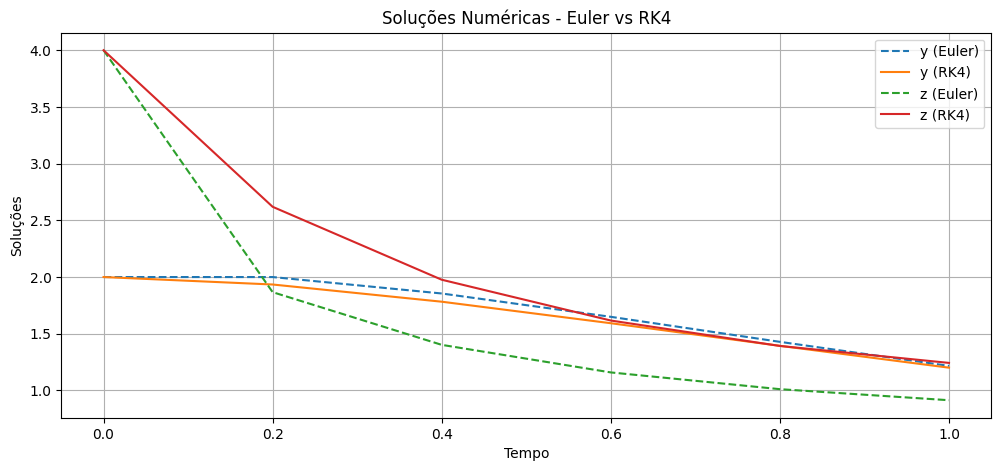


Tabela dos valores por passo:
   Passo     |      t       |   y Euler    |   z Euler    |    y RK4     |    z RK4    
------------------------------------------------------------------------------------------
     0       |    0.0000    |   2.000000   |   4.000000   |   2.000000   |   4.000000  
     1       |    0.2000    |   2.000000   |   1.866667   |   1.934213   |   2.619319  
     2       |    0.4000    |   1.854985   |   1.402074   |   1.782542   |   1.976343  
     3       |    0.6000    |   1.649247   |   1.158971   |   1.592793   |   1.616511  
     4       |    0.8000    |   1.428597   |   1.011285   |   1.393480   |   1.392448  
     5       |    1.0000    |   1.216622   |   0.913883   |   1.200827   |   1.242899  

=== Valores finais em t = 1.0000 ===
y (Euler): 1.216622
y (RK4)  : 1.200827
z (Euler): 0.913883
z (RK4)  : 1.242899


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

def euler_system(f, t0, y0, h, n_steps):
    t_values = [t0]
    y_values = [y0.copy()]
    t = t0
    y = y0.copy()
    for _ in range(n_steps):
        y += h * f(t, y)
        t += h
        t_values.append(t)
        y_values.append(y.copy())
    return np.array(t_values), np.array(y_values)

def rk4_system(f, t0, y0, h, n_steps):
    t_values = [t0]
    y_values = [y0.copy()]
    t = t0
    y = y0.copy()
    for _ in range(n_steps):
        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + h/2, y + k2/2)
        k4 = h * f(t + h, y + k3)
        y += (k1 + 2*k2 + 2*k3 + k4) / 6
        t += h
        t_values.append(t)
        y_values.append(y.copy())
    return np.array(t_values), np.array(y_values)

# ==============================
# Entrada do usuário
# ==============================

print("=== RESOLUÇÃO DE EDOs ===")
n = int(input("Número de equações no sistema (1 para solução analítica): "))

# Solicita os nomes das variáveis
variaveis = []
print("Digite os nomes das variáveis (ex: x, v, z):")
for i in range(n):
    nome = input(f"Nome da variável {i+1}: ")
    variaveis.append(nome)

# Solicita as equações
print("\nDigite o lado direito de cada equação usando os nomes das variáveis, 't', e funções matemáticas (exp, sin, cos, e, etc.)")
equacoes = []
for i in range(n):
    eq = input(f"d{variaveis[i]}/dt = ")
    equacoes.append(eq)

# Define a função do sistema numérico
def sistema(t, y):
    local_vars = {
        "t": t,
        "e": np.e,
        "exp": np.exp,
        "sin": np.sin,
        "cos": np.cos,
        "tan": np.tan,
        "log": np.log,
        "sqrt": np.sqrt,
        "pi": np.pi
    }
    for i, var in enumerate(variaveis):
        local_vars[var] = y[i]
    derivadas = [eval(expr, {}, local_vars) for expr in equacoes]
    return np.array(derivadas, dtype=float)

# Condições iniciais
print("\nCondições iniciais:")
y0 = []
for var in variaveis:
    val = float(input(f"{var}(t0) = "))
    y0.append(val)
y0 = np.array(y0)

# Intervalo e passo
t0 = float(input("\nTempo inicial t0: "))
tf = float(input("Tempo final tf: "))
h = float(input("Tamanho do passo h: "))
n_steps = int((tf - t0) / h)

# ==============================
# Cálculo numérico
# ==============================

t_euler, y_euler = euler_system(sistema, t0, y0.copy(), h, n_steps)
t_rk4, y_rk4 = rk4_system(sistema, t0, y0.copy(), h, n_steps)

# ==============================
# Solução simbólica (se n == 1)
# ==============================

if n == 1:
    print("\nTentando resolver simbolicamente...")
    t, y = sp.symbols('t y')
    try:
        ode = sp.Eq(sp.Derivative(y, t), eval(equacoes[0].replace(variaveis[0], 'y')))
        sol = sp.dsolve(ode, y)
        C1 = sp.symbols('C1')
        # Aplicando condição inicial y(t0) = y0[0]
        sol_func = sol.rhs
        sol_const = sp.Eq(sol_func.subs(t, t0), y0[0])
        c_val = sp.solve(sol_const, C1)
        if c_val:
            sol_func = sol_func.subs(C1, c_val[0])
        print(f"Solução simbólica: y(t) = {sol_func}")

        # Converter para função lambda para comparar numericamente
        y_exact = sp.lambdify(t, sol_func, modules=["numpy"])
        t_exact = np.linspace(t0, tf, 1000)
        y_exact_vals = y_exact(t_exact)

        # Plot com solução simbólica
        plt.figure(figsize=(12, 5))
        plt.plot(t_euler, y_euler[:, 0], '--', label='Euler')
        plt.plot(t_rk4, y_rk4[:, 0], '-', label='RK4')
        plt.plot(t_exact, y_exact_vals, 'k:', label='Solução Analítica')
        plt.xlabel("Tempo")
        plt.ylabel("y(t)")
        plt.legend()
        plt.title("Comparação: Euler, RK4 e Solução Analítica")
        plt.grid()
        plt.show()
    except Exception as e:
        print("Não foi possível resolver simbolicamente:", e)
else:
    # Plot numérico para sistemas
    plt.figure(figsize=(12, 5))
    for i in range(n):
        plt.plot(t_euler, y_euler[:, i], '--', label=f'{variaveis[i]} (Euler)')
        plt.plot(t_rk4, y_rk4[:, i], '-', label=f'{variaveis[i]} (RK4)')
    plt.xlabel("Tempo")
    plt.ylabel("Soluções")
    plt.title("Soluções Numéricas - Euler vs RK4")
    plt.grid()
    plt.legend()
    plt.show()
# ==============================
# Tabela com valores por passo
# ==============================

print("\nTabela dos valores por passo:")
header = ["Passo", "t"] + \
         [f"{var} Euler" for var in variaveis] + \
         [f"{var} RK4" for var in variaveis]

print(" | ".join(f"{h:^12}" for h in header))
print("-" * (15 * len(header)))

for i in range(len(t_euler)):
    row = [f"{i:^12d}", f"{t_euler[i]:^12.4f}"]
    row += [f"{y_euler[i,j]:^12.6f}" for j in range(n)]
    row += [f"{y_rk4[i,j]:^12.6f}" for j in range(n)]
    print(" | ".join(row))

# ==============================
# Saída final
# ==============================

print("\n=== Valores finais em t = %.4f ===" % tf)
for i in range(n):
    print(f"{variaveis[i]} (Euler): {y_euler[-1, i]:.6f}")
    print(f"{variaveis[i]} (RK4)  : {y_rk4[-1, i]:.6f}")
